In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaincc as gammq
from jv_simulation import experiment
from jv import solve_pde, delta_h, phi
from scipy.optimize import minimize

# Parameter Fitting Experiments

This notebook contains Python experiments following Chapter 15 in Numerical Recipes in Fortran by Press et. al.

## Fitting Data to a Straight Line

In the simplest case, we want to fit a straight line $y(x) = a + bx$ to some set of data. There are three things we want to quantify/estimate (1) the values of model parameters, (2) error estimates on those values, and (3) a goodness-of-fit estimate. Formulas to estimate each of these in a straight-line model are given in section 15.2.

For our experiments, we first want to generate some sample data. Let's restrict $x$ to the interval $[0, 1)$. Pick a random $a$ and $b$ to be the true model, and generate data $y_i = a + bx_i + \eta_i$ where $\eta_i$ is a white noise term with 0 mean and variance $\sigma_i^2$. Let's take $N = 20$ to be the number of data points, and pick the $x_i$'s randomly. We also need to specify a $\sigma_i^2$ (measurement error) for each data point. For no particular reason, let's say $\sigma_i^2 = (2 + x_i^2)/10$.

In [2]:
def variance(x):
    return (2 + x**2)/10

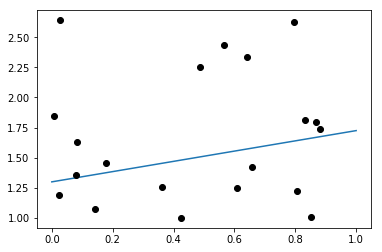

In [3]:
a, b = np.random.rand(2)*3
N = 20
xi = np.random.rand(N)
yi = a + b*xi + np.random.randn(N)*np.sqrt(variance(xi))
x = np.linspace(0, 1)
plt.plot(x, a+b*x)
plt.plot(xi, yi, 'ko')
plt.show()

Now that we have sample data, we can estimate $a$, $b$, $\sigma_a$, $\sigma_b$, $\chi^2$, and $q$.

In [4]:
sig = np.sqrt(variance(xi))
sx = np.sum(xi/sig**2)
sy = np.sum(yi/sig**2)
ss = np.sum(1./sig**2)
ti = (xi - sx/ss)/sig
st = np.sum(ti**2)
samp_b = np.sum(ti*yi/sig)/st
samp_a = (sy - sx*b)/ss
sig_a = (1 + sx**2/(ss*st))/ss
sig_b = 1/st
chi2 = np.sum(((yi - a - b*xi)/sig)**2)
q = gammq((N-2)/2, chi2/2)

In [5]:
print(
    '$a = {:g}$\n$b = {:g}$\n$\sigma_a^2 = {:g}$\n$\sigma_b^2 = {:g}$\n$\chi^2 = {:g}$\n$q = {:g}$'
    .format(samp_a, samp_b, sig_a, sig_b, chi2, q))

$a = 1.47764$
$b = 0.150924$
$\sigma_a^2 = 0.0321717$
$\sigma_b^2 = 0.113213$
$\chi^2 = 27.5835$
$q = 0.0686831$


## Fitting the model average velocity distribution to random samples

In the jump-velocity model, there is no independent variable that is being sampled experimentally. Instead, platelet rolling is some stochastic process that generates realizations of a random variable that depends on that process: the average velocity. There is some underlying distribution of the average rolling velocity that we hope is well approximated by our jump velocity model. One way to estimate parameters in the model from the data is to use a maximum-likelihood estimate, similar to the process described in section 15.1 of *Numerical Recipes*. 

For a set of measurements of average rolling velocity $\{v_i\}_{i=1}^N$, define the likelihood function $L(a, \epsilon)$ to be the joint probability density of the sample data $f(v_1, v_2, ..., v_N; a, \epsilon)$. For i.i.d. samples, $L(a, \epsilon) = \prod_{i=1}^N f(v_i; a, \epsilon)$. Then the goal is to find the parameter values $a$ and $\epsilon$ that maximize the likelihood function.

It is more convenient to define $\hat{\ell} = \log L$ and maximize $\ell$ instead, so define $\hat{\ell}(a, \epsilon) = \log L(a, \epsilon) = \sum_{i=1}^N \log f(v_i; a, \epsilon)$. In the jump velocity model we have $f(v) = q_U(1, 1/v)/v^2$, so we substitute this into the log-likelihood: $\hat{\ell}(a, \epsilon) = \sum_{i=1}^N [\log q_U(1, 1/v_i; a, \epsilon) - 2\log v_i]$. The second term in the sum is constant w.r.t. $a$ and $\epsilon$, so it doesn't affect the optimization procedure and can be excluded. Therefore define $\ell(a, \epsilon) = \sum_{i=1}^N \log q_U(1, 1/v_i; a, \epsilon)$ and we want to find $\hat{a}$ and $\hat{\epsilon}$ which maximize $\ell$.

### Simplest case: two states with adiabatic reduction

As a first test case, assume that $\epsilon << 1$ and use the adiabatic reduction to fit $a$ and $\epsilon$. In this case, we can express $q_U$ analytically: $q_U(y, s) = \frac{1}{\sqrt{4\pi\epsilon a(1 - a)s}} \left(a + \frac{y - a s}{2s}\right)\exp\left(\frac{-(y - as)^2}{4\epsilon a (1 - a) s}\right)$.

First, choose a set of parameters:

In [6]:
a, epsilon = .5, .1

Then generate a bunch of sample data.

In [7]:
N = 1000
rate_a = a/epsilon
rate_b = (1 - a)/epsilon
v_list = list()
for _ in range(N):
    while True:
        v = experiment(rate_a, rate_b, 0, 0)
        if v < 1: 
            break
    v_list.append(v)

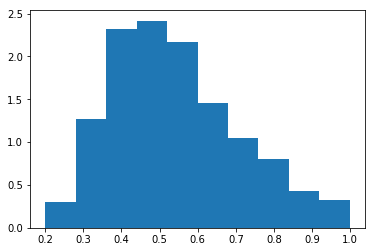

In [8]:
plt.hist(v_list, density=True)
plt.show()

In [9]:
def q(y, s, a, eps):
    return 1/np.sqrt(4*np.pi*eps*a*(1-a)*s)*(a + (y - a*s)/(2*s))*np.exp(-(y - a*s)**2/(4*eps*a*(1-a)*s))

In [10]:
def adlnlikelihood(p, vectorized=False):
    if vectorized:
        v = np.array(v_list)[:, None, None]
        s = p[0][None, :, None]
        ap = np.select([s==0, s!=0], [0.5, (s - 1 + np.sqrt(s**2 + 1))/(2*s)])
        epsp = np.exp(p[1][None, None, :])
        return -np.sum(np.log(q(1, 1./v, ap, epsp)), axis=0)
    else:
        v = np.array(v_list)
        s = p[0]
        if s == 0:
            ap = .5
        else:
            ap = (s - 1 + np.sqrt(s**2 + 1))/(2*s)
        epsp = np.exp(p[1])
        return -np.sum(np.log(q(1, 1./v, ap, epsp)))

In [11]:
def lnlikelihood(p):
    # Transform the parameters back to a and epsilon
    s = p[0]
    if s == 0:
        ap = .5
    else:
        ap = (s - 1 + np.sqrt(s**2 + 1))/(2*s)
    eps = np.exp(p[1])
    
    # Find the minimum sampled average velocity
    v = np.array(v_list)
    vmin = np.amin(v)
    
    N = 1000
    h = 1./N
    s_eval = (np.arange(0, np.ceil(1./(vmin*h))) + 1) * h
    
    # Define initial conditions for solve_pde
    y = np.linspace(0, 1, num=N + 1)
    u_init = delta_h(y[1:], h)
    p0 = np.append(u_init, np.zeros(4 * N))
    
    u1_bdy = solve_pde(s_eval, p0, h, eps1=eps, eps2=np.inf, a=ap, b=1 - ap, c=1, d=0, scheme='up')[3]
    q = np.interp(1. / v, s_eval, u1_bdy)
    return -np.sum(np.log(q))

As mentioned above, we want to find $a$ and $\epsilon$ which maximize the log-likelihood function $\ell(a, \epsilon)$. We want to optimize within some finite domain in $a$ and $\epsilon$, in particular $a \in [0, 1]$ and $\epsilon \in (0, \infty)$. We could use an optimization routine which optimizes with constraints, but I was encountering overflow issues when trying to use SciPy's optimizers with $a$ restricted to $[0, 1]$. I suspect this is because $\ell \rightarrow -\infty$ quickly as $a \rightarrow \text{0 or 1}$.

In addition, if $\epsilon << 1$, the optimization error may be of the same order as $\epsilon$ itself. We may be more interested in an order-of-magnitude estimate of $\epsilon$ than its precise value.

Therefore I transform each of the parameters $\tilde{a} = \frac{2a - 1}{2a(1-a)}$ and $\tilde{\epsilon} = \log\epsilon$ and optimize $\tilde{\ell}(\tilde{a}, \tilde{\epsilon})$. Now we can use unconstrained optimization, and we have eliminated issues at the boundaries $a = 0$, $a = 1$, and $\epsilon = 0$.

The reverse transformations are given by $\epsilon = \exp(\tilde{\epsilon})$ and $a = \frac{\tilde{a} - 1 + \sqrt{\tilde{a}^2 + 1}}{2\tilde{a}}$.

Another issue is that of the initial guess in the optimizer. Because we need to solve a PDE at every parameter update in the optimizer, it helps to have a good initial guess. One possibility is to use the adiabatic reduction to estimate $a$ and $\epsilon$ first, and use the result of that as the initial guess in the full optimizer.

However, this doesn't remove the issue of needing an initial guess, because an iterative optimization routine is still finding the MLE for $a$ and $\epsilon$ in the adiabatic reduction. Therefore, I try using the mean of $v$ and the standard deviation of $v$ to generate a guess for the starting values of $a$ and $\epsilon$.

In [12]:
a0 = np.mean(v_list)
e0 = np.std(v_list)
s0 = (2*a0 - 1)/(2*a0*(1-a0))
le0 = np.log(e0)

In [13]:
sol = minimize(adlnlikelihood, np.array([s0, le0]))

In [14]:
sol.x

array([ 0.07088857, -2.28657627])

In [15]:
np.log(.1)

-2.3025850929940455

In [23]:
adlnlikelihood(sol.x)

903.4479279249623

In [24]:
lnlikelihood(sol.x)

1594.2024343912542

In [18]:
%timeit lnlikelihood(sol.x)

947 ms ± 58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
e0 = np.std(v_list)**2/(2*a0*(1-a0))

In [20]:
e0

0.05589964363371291

In [21]:
np.log(e0)

-2.884197273909152

In [22]:
s0

0.1736224173504607